# Enron case

### Background

The Enron case (2002) was a financial scandal that led to the bankruptcy of the Enron Corporation, one of the largest companies in the United States, due to widespread corporate fraud.

Kenneth Lay founded Enron, an American energy company based in Houston, Texas, in 1985 through the merger of Houston Natural Gas and Internorth, two natural gas pipeline companies. 

In an attempt to achieve further growth, Enron pursued a diversification
strategy. It began by reaching beyond its pipeline business to become involved in
natural gas trading. It extended the natural gas model to become a financial trader
and market maker in electric power, coal, steel, paper and pulp, water and
broadband fiber optic cable capacity.

From the start of the 1990s until year-end 1998, Enron’s stock rose by
311 percent, only modestly higher than the rate of growth in the Standard
& Poor’s 500. But then the stock soared. It increased by 56 percent in 1999
and a further 87 percent in 2000, compared to a 20 percent increase and a
10 percent decline for the index during the same years. By December 31, 2000,
Enron’s stock was priced at 83.13, and its market capitalization exceeded 60 billion,
70 times earnings and six times book value, an indication of the stock market’s
high expectations about its future prospects. Enron was rated the most innovative
large company in America in Fortune magazine’s survey of Most Admired Companies.
Yet within a year, Enron’s image was in tatters and its stock price had plummeted nearly to zero.

### Objective

The goal of this project is to build a Person Of Interest (POI) identifier based on financial and email data made public as a result of the Enron scandal. 

In order to build this identifier a dataset is analyzed using machine learning algorithms. This dataset contains a hand-generated list of persons of interest in the fraud case, which means individuals who were indicted, reached a settlement or plea deal with the government, or testified in exchange for prosecution immunity.
##### Why Machine Learning?
Machine learning is an application of AI that allows us to be more accurate in predicting outcomes, giving input data to machines and let them learn for themselves. Implementing some of the algorithms that Machine Learning reduces worktime increasing accuracy.



# Data exploration

In [3]:
import sys
import cPickle as pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import recall_score, precision_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold
sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
import tester

In [111]:
#functions
def impute_median(series):
    return series.fillna(series.median())

def features_graph(data,features):
    plt.scatter( data[features[0]], data[features[1]] )
    plt.xlabel(features[0])
    plt.ylabel(features[1])
    ti = ' '.join([features[0],'vs',features[1]])
    plt.title(ti)
    plt.xticks(rotation=90)
    plt.show()
    
def frac(x):
    poi_messages = x[0]
    all_messages = x[1]
    fraction = float(poi_messages)/float(all_messages)

    return fraction

def split_data(features,labels,cv):
    features = np.array(features)
    labels = np.array(labels)
    train_index, test_index = next(iter(cv.split(features, labels)))

    X_train = features[train_index]
    y_train = labels[train_index]
    X_test = features[test_index]
    y_test = labels[test_index]
    
    return X_train, y_train, X_test, y_test

def grid_SelectKBest_DecisionTree(features, labels):
    pipe = make_pipeline(SelectKBest(),DecisionTreeClassifier())
    param_grid = {'decisiontreeclassifier__criterion': ['gini', 'entropy'],
             'decisiontreeclassifier__max_depth': [None, 1,2,3],
             'decisiontreeclassifier__min_samples_split': [2, 4],
             'decisiontreeclassifier__min_samples_leaf': [1, 2, 4, 6],
         'selectkbest__k':[4,6,8,10, 'all']}
    grid = GridSearchCV(pipe, param_grid = param_grid, cv=cv, scoring = 'f1')
    return grid.fit(features, labels)


def grid_PCA_GaussianNB(features, labels):
    pipe = make_pipeline(PCA(),GaussianNB())
    param_grid =[{"pca__n_components": [2,3,4]}]
    grid = GridSearchCV(pipe,param_grid,cv=cv, scoring = 'f1')
    return grid.fit(features, labels)

def grid_score(features, labels, c, md, mss, msl):
    pipe = make_pipeline(SelectKBest(),DecisionTreeClassifier(criterion=c, max_depth =md,
                                                    min_samples_split=mss, min_samples_leaf=msl))
    param_grid = {'selectkbest__k':[4,6,8,10, 'all']}
    grid = GridSearchCV(pipe, param_grid = param_grid, cv=cv, scoring = 'f1')
    grid.fit(features, labels)
    results = pd.DataFrame(grid.cv_results_)
    return results[['mean_test_score','param_selectkbest__k']]


In [5]:
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)
enron = pd.DataFrame.from_dict(data_dict, orient = 'index')

In [6]:
enron.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, ALLEN PHILLIP K to YEAP SOON
Data columns (total 21 columns):
salary                       146 non-null object
to_messages                  146 non-null object
deferral_payments            146 non-null object
total_payments               146 non-null object
exercised_stock_options      146 non-null object
bonus                        146 non-null object
restricted_stock             146 non-null object
shared_receipt_with_poi      146 non-null object
restricted_stock_deferred    146 non-null object
total_stock_value            146 non-null object
expenses                     146 non-null object
loan_advances                146 non-null object
from_messages                146 non-null object
other                        146 non-null object
from_this_person_to_poi      146 non-null object
poi                          146 non-null bool
director_fees                146 non-null object
deferred_income              146 non-null object


There are 146 entries with 21 features, divided in financial and email features.

Financial features include items such as salary, total stock value, expenses or exercised stock options. All units in financial features are in US dollars. Email features describe who sent the message and to whom, and whether any of these persons was a POI. In this case units are generally the number of emails messages sent or received. The exception is “email address” which is a text string.

The POI label, which is a boolean represented as integer, tells us whether the person is a poi or not.

In [7]:
poi = enron['poi']==1

print poi.value_counts()

False    128
True      18
Name: poi, dtype: int64


There are 18 POI and 128 non POI. This means that 12.3% of the people in the sample are POIs.

##### Missing values

In [8]:
enron.replace(to_replace='NaN', value=np.nan, inplace=True)
null = enron.isnull().sum().sort_values(ascending=False)
print null

loan_advances                142
director_fees                129
restricted_stock_deferred    128
deferral_payments            107
deferred_income               97
long_term_incentive           80
bonus                         64
from_poi_to_this_person       60
shared_receipt_with_poi       60
to_messages                   60
from_this_person_to_poi       60
from_messages                 60
other                         53
expenses                      51
salary                        51
exercised_stock_options       44
restricted_stock              36
email_address                 35
total_payments                21
total_stock_value             20
poi                            0
dtype: int64


The dataset contains many Nan values. For financial features most of them actually represent 0 instead of missing values.

In [9]:
poi = enron['poi']==1
no_email_info = enron['to_messages'].isnull()
poi_no_email_info = poi & no_email_info


print poi_no_email_info.value_counts()


False    142
True       4
dtype: int64


In [10]:
print enron[poi_no_email_info].index.values

['FASTOW ANDREW S' 'HIRKO JOSEPH' 'KOPPER MICHAEL J' 'YEAGER F SCOTT']


In the email features there is missing information for 60 entries, of which 4 are POI. In this case those values will be filled with the median of each email feature.

In [11]:
email_features = ['to_messages', 'from_messages', 'from_this_person_to_poi', 'from_poi_to_this_person',
                  'shared_receipt_with_poi']

by_poi = enron.groupby(['poi'])
enron[email_features] = by_poi[email_features].transform(impute_median)

## Outlier Investigation

Visualizing the data is a good way to find outliers in the dataset. Through the following graph we compare salaries and bonuses to identify potential outliers.

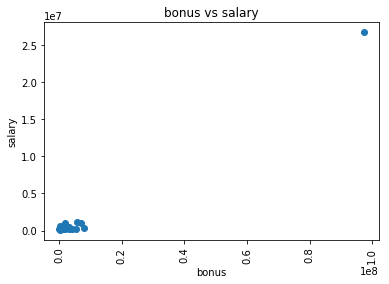

In [12]:
features = ['bonus','salary']
features_graph(enron,features)

In [13]:
enron[enron['salary']>20000000].index.values

array(['TOTAL'], dtype=object)

Looking at the the graph we see a data point noticeably apart from the rest of the sample. Checking the data we realize that this entry corresponds to the total, the sum of all salaries and bonuses of each person in the dataset. Thus we eliminate this entry from the sample and we refresh the graph to get a closer look to the distribution.

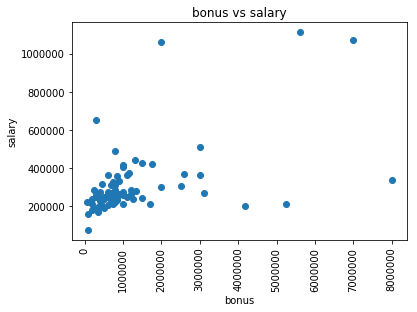

In [14]:
enron = enron.drop(['TOTAL'])
features_graph(enron,features)

In [15]:
sal = enron['salary']>800000
bonu = enron['bonus']>5000000

enron[sal & bonu].index.values

array(['LAY KENNETH L', 'SKILLING JEFFREY K'], dtype=object)

There are 4 more outliers to investigate. Two people made bonuses of at least 5 million dollars, and a salary of over 1 million dollars; in other words. What are the names associated with those points? LAY KENNETH L, SKILLING JEFFREY K. we should leave them because they are valid data piont

## Create new features

The are five given email features: from_poi_to_this_person, to_messages, from_this_person_to_poi, from_messages, shared_receipt_with_poi. From these we create three new features, which describe the percentage of the user’s total emails that are received from or sent to POI’s. 

- fraction_from_poi: Is the proportion of the emails sent from a POI to this person of all the email received. 
- fraction_to_poi: Is the proportion of the emails sent to this person to a POI of all the email sent.
- fraction_shared_poi: Is the proportion of the emails that shared receipt with a POI of all the email recieved.

These features are created because the proportion tell us more information than only the number, for example, if a person sent 20 email to a POI and in total sent 100 it is different than a person who also sent 20 emails to a POI of a total of 25. The second person has a higher proportion and thus his interactions are mainly to POIs, indicating that he has a greater implication with suspects.

This way we can identify the relevance of the users’ interaction with POIs in the total amount of emails they receive.

In [16]:
enron["fraction_from_poi"] = enron[["from_poi_to_this_person","to_messages"]].apply(frac, axis = 1)
enron["fraction_to_poi"] = enron[["from_this_person_to_poi","from_messages"]].apply(frac, axis = 1)
enron["fraction_shared_poi"] = enron[["shared_receipt_with_poi","to_messages"]].apply(frac, axis = 1)

## Feature Selection

THE TRAVEL AGENCY IN THE PARK corresponds to a company co-owned by LAY’s younger sister Sharon Lay. As it is not a person directly working at ENRON, we eliminate this entry. 

We also delete the feature called “mail address” as it does not give us valuable information for the purpose of the analysis. Finally we eliminate total_stock_value,total_payments as it is the sum of features which already exist.

For the following analysis we keep the pre existing an the newly created email features in order to compare which ones are more relevant for the algorithm's performance.

In [17]:
enron = enron.drop(['THE TRAVEL AGENCY IN THE PARK'])

In [21]:
features_list = ['poi','salary', 'deferral_payments', 'loan_advances', 'bonus', 
                     'restricted_stock_deferred', 'deferred_income', 'expenses', 'exercised_stock_options', 
                     'other', 'long_term_incentive', 'restricted_stock', 'director_fees', 
                     "fraction_shared_poi","fraction_from_poi","fraction_to_poi","from_poi_to_this_person",
                 "to_messages","from_this_person_to_poi","from_messages",'shared_receipt_with_poi'] 

enron.replace(to_replace=np.nan, value='NaN', inplace=True)
my_dataset = enron.to_dict('index')

In [22]:
data = featureFormat(my_dataset, features_list, remove_NaN=True, sort_keys = True)
labels, features = targetFeatureSplit(data)

These previous features were selected by hand. Now we are going to study how relevant features are based on univariate statistical tests, using the SelectKBest algorithm. 

#### SelectKBest
This algorithm select features with highest scores. This score is measured by the ANOVA F-value between each feature and the target value. the amount of features that keeps is seting by the K parameter.

In [23]:
selector = SelectKBest()
selector.fit(features, labels)
scores = selector.scores_ 

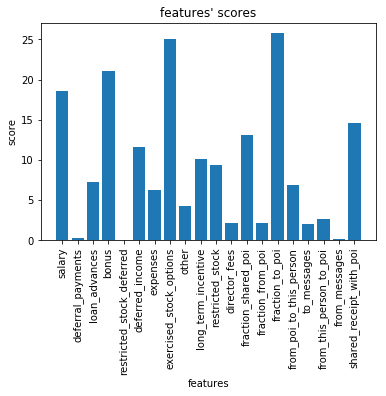

In [24]:
x = np.arange(len(features_list)-1)
plt.bar(x,scores)
plt.xticks(x, features_list[1:],rotation=90)

plt.xlabel('features')
plt.ylabel('score')
plt.title("features' scores")
plt.show()

The graph shows that two features with high influence were created in the past step (fraction_shared_poi and fraction_to_poi), where fraction_to_poi is the feature with the higher score. In the next step we are going to evaluate how different K values impact the model's performance.

## Overview

Before building a machine learning model we take a general look at the features' behavior. To make a manageable graph I took only the six features with the highest score. These are: salary, bonus, deferred income, exercised stock options (financial features), fraction shared poi, fraction to poi (email features).

In [25]:
new_features= ['poi','salary', 'bonus', 'exercised_stock_options', 
                'fraction_shared_poi', 'fraction_to_poi','shared_receipt_with_poi']

data = featureFormat(my_dataset, new_features, remove_NaN=True, sort_keys = True)
l, f = targetFeatureSplit(data)

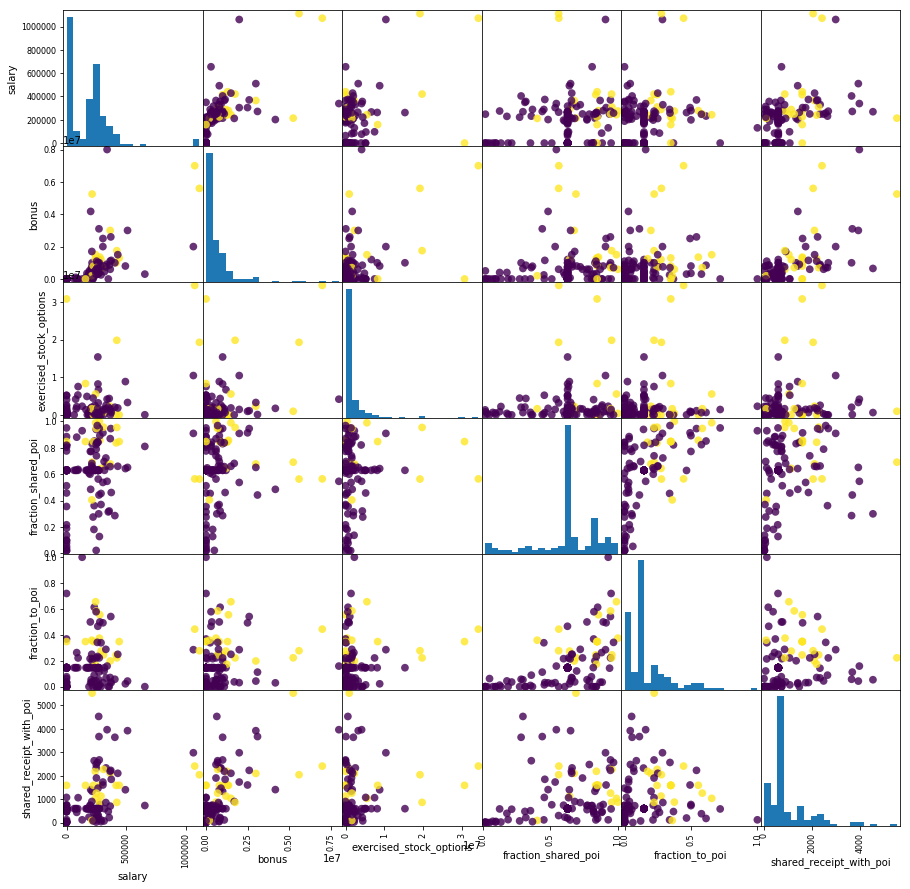

In [26]:
enron_dataframe = pd.DataFrame(f, columns= new_features[1:])
pd.plotting.scatter_matrix(enron_dataframe, c=l, figsize=(15,15), 
                        marker = 'o', hist_kwds={'bins': 20}, s=60,alpha=.8)
plt.show()

Data from POIs is shown in yellow dots while non POIs are shown in purple. POIs and non-POIs seem to be separated especially for the feature exercised_stock_options.

## Scaling features

Any algorithm that computes distance or assumes normality requires to do feature rescaling. K means clustering and SVM with RBF kernel would be affected by feature rescaling. Decision trees and linear regression don’t need it. 

As some algorithms that will be analyzed don’t require to reescale features, Pipeline is used to reescalate features for those that need it.

## Pick an algorithm

Now we can build the machine learning model, by analyzing perfomance of three different algorithms: RBF SVM, Naive Bayes and Decision Tree.

To split the data we use stratified k fold because of the low POI’s share in the dataset. With this method the folds created preserve the percentage of samples for each class.

In [27]:
cv = StratifiedKFold(n_splits = 5)
X_train, y_train, X_test, y_test = split_data(features,labels,cv)

To begin, the models will be evaluating with all the features and with its default parameters.


In [28]:
names = ["RBF SVM", "Naive Bayes","Decision Tree"]
classifiers = [make_pipeline(MinMaxScaler(),SVC()), GaussianNB(),DecisionTreeClassifier()]
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    print name, ": ", score

RBF SVM :  0.866666666667
Naive Bayes :  0.7
Decision Tree :  0.933333333333


We can see that the Decision Tree model´s accuracy was 0.93, which means that 93% of test data was correctly predicted. In the case of RBF SVM and Naive Bayes models accuracy was lower, 0.86 and 0.7 respectively.

## Parameter tuning and its importance

parameter tuning is a key component of the machine learning process. It enables algorithms to maximize perfomance according to objectives that are previously defined. In order to do it, parameter tuning tries different values for each of the algorithm’s parameters in order to find the combination that maximizes perfomance. If parameters are not well tuned, the algorithm will not work at its full potential.
Some commonly used methods are GridSearchCV and RandomizedSearchCV, which try all possible parameters of interest.

## Tune the algorithm

To evaluate the algorithm’s performance I used the GridSearchCV method. I will also use Pipeline, which allows to chain multiple estimators into one. This allows us to evaluate if it is necessary to apply a preprocessing method, as feature selection, to further increase perfomance.

In the case of the Decision Tree’s model the parameters that will be tuned are:
- criterion: "The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain."
- min_samples_split: "The minimum number of samples required to split an internal node"
- min_samples_leaf: 'The minimum number of samples required to be at a leaf node'
- max_depth: "The maximum depth of the tree"

And for SelectKBest algorithm:
- k: 'Number of top features to select'

The values for those parameters that will be evaluated are:
- Decision Tree:
    - criterion: ['gini', 'entropy']
    - min_samples_split: [2, 4]
    - min_samples_leaf: [1, 2, 4, 6]
    - max_depth: [None, 1, 2, 3]


- SelectKBest:
    - k: [4, 6, 8, 10, "all"]

The algorithms will be tried with 3 cases: the first is the model that contains all the features including the new ones (mails' proportions), the second without the new features created, and the last replacing the email features with the new created.
The optimal model will be achieved by maximizing the F1 score, which allows to find the model that has the better precision and recall results. The F1 score is the harmonic average of precision and recall.

In [64]:
grid = grid_SelectKBest_DecisionTree(features,labels)

print grid.best_params_
print grid.best_score_

{'decisiontreeclassifier__min_samples_leaf': 2, 'decisiontreeclassifier__min_samples_split': 2, 'selectkbest__k': 'all', 'decisiontreeclassifier__max_depth': None, 'decisiontreeclassifier__criterion': 'entropy'}
0.749242424242


In [65]:
features_list_n = ['poi','salary', 'deferral_payments', 'loan_advances', 'bonus', 
                     'restricted_stock_deferred', 'deferred_income', 'expenses', 'exercised_stock_options', 
                     'other', 'long_term_incentive', 'restricted_stock', 'director_fees',"from_poi_to_this_person",
                 "to_messages","from_this_person_to_poi","from_messages",'shared_receipt_with_poi'] 

features_list_p = ['poi','salary', 'deferral_payments', 'loan_advances', 'bonus', 
                     'restricted_stock_deferred', 'deferred_income', 'expenses', 'exercised_stock_options', 
                     'other', 'long_term_incentive', 'restricted_stock', 'director_fees', 
                     "fraction_shared_poi","fraction_from_poi","fraction_to_poi"] 

data_n = featureFormat(my_dataset, features_list_n, remove_NaN=True, sort_keys = True)
data_p = featureFormat(my_dataset, features_list_p, remove_NaN=True, sort_keys = True)
labels_n, features_n = targetFeatureSplit(data_n)
labels_p, features_p = targetFeatureSplit(data_p)

grid_n = grid_SelectKBest_DecisionTree(features_n,labels_n)
grid_p = grid_SelectKBest_DecisionTree(features_p,labels_p)

In [66]:
print grid_n.best_params_
print grid_n.best_score_

{'decisiontreeclassifier__min_samples_leaf': 1, 'decisiontreeclassifier__min_samples_split': 4, 'selectkbest__k': 'all', 'decisiontreeclassifier__max_depth': 2, 'decisiontreeclassifier__criterion': 'entropy'}
0.530665784832


In [67]:
print grid_p.best_params_
print grid_p.best_score_

{'decisiontreeclassifier__min_samples_leaf': 1, 'decisiontreeclassifier__min_samples_split': 2, 'selectkbest__k': 'all', 'decisiontreeclassifier__max_depth': 2, 'decisiontreeclassifier__criterion': 'entropy'}
0.753780864198


We can see that it was not neccesary to apply a feature selection because in the 3 cases the optimal k value for SelectKBest algorithm is "all", and that means all the features stay.

Parameters selected for the Decision Tree model were:
- All features (proportions and numbers email features):
    - criterion: 'entropy'
    - min_samples_split: 2
    - min_samples_leaf: 2
    - max_depth: None
    
    
    
- Only email features in numbers:
    - criterion: 'entropy'
    - min_samples_split: 4
    - min_samples_leaf: 1
    - max_depth: 2      
    
    
    
- Only email features in proportions:
    - criterion: 'entropy'
    - min_samples_split: 2
    - min_samples_leaf: 1
    - max_depth: 2
    
The accuracy of the models (the percentage of correct predictions) were 75%, 53%, 75% respectively (aprox).


For the Naive Bayes model I used the default parameters.

In [68]:
grid = grid_PCA_GaussianNB(features, labels)
grid_n = grid_PCA_GaussianNB(features_n, labels_n)
grid_p = grid_PCA_GaussianNB(features_p, labels_p)


print grid.best_params_
print grid.best_score_

print grid_n.best_params_
print grid_n.best_score_

print grid_p.best_params_
print grid_p.best_score_

{'pca__n_components': 4}
0.365740740741
{'pca__n_components': 4}
0.365740740741
{'pca__n_components': 4}
0.365740740741


In those cases, we can see than the accuracy is very low, only 37% of the points were predicted correctly. As a result, I will continue the analysis only with the Decision Tree algorithm, studying the two cases with the highest score, the one that has all the features (original email features and new emails features) and the one that replaced the original emails features for the new created.

#### Scores for different K parameter values using the SelectKbest method

Next I study the evolution of the F1 score for the two models chosen in the previous section.

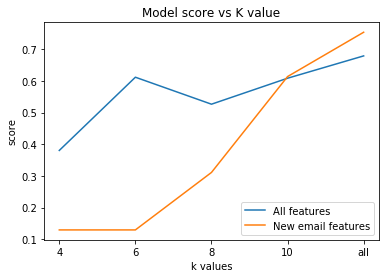

In [135]:
result = grid_score(features, labels, 'entropy', None, 2, 2)
result2 = grid_score(features_p, labels_p, 'entropy', 2, 2, 1)

x = np.arange(5)
plt.plot(x,result['mean_test_score'])

plt.plot(x,result2['mean_test_score'])
plt.xticks(x, result['param_selectkbest__k'])

plt.xlabel('k values')
plt.ylabel('score')
plt.title("Model score vs K value")
plt.legend(['All features', 'New email features'], loc=4)
plt.show()



Five different values of the parameter K were taken: 4, 6, 8, 10 and all. In the case of the model that has all features we can see that the score is always over 0.45, having two peaks (in 6 featues and in all features) of 0.7 approx. For the other case the k values of 4 and 6 features have very low scores, of less than 0.15, then it starts to rise and when the parameter is 10 it passes the score of the model with all features.

## Validation and its importance.

Validation is used to evaluate the performance of the chosen model. So far we have seen a 93% accuracy rate in our subject of study. However, it is necessary to use other evaluation metrics to obtain a more complete prediction rate. 

In some cases using only accuracy may not be appropiate. It is important to choose the right metric when selecting between models and adjusting parameters. For example, a typical mistake is trusting only in accuracy rates with imbalanced datasets. An imbalanced dataset means that a class is more frequent than others. In our database POIs are less frequent than Non-POIs, just 12.3% of the total. As such, a model may predict Non-POIs effectively only because of its relative weight in the dataset.
## Evaluation Metrics
A way to study these imbalanced datasets is using precision and recall methods. In the first the question is how many of all the items labeled as positive truly belong to the positive class. In the recall method the question how many items were correctly classified as positive out of all that are truly positive.
-  recall = True Positive / (True Positive + False Negative)

- precision = True Positive / (True Positive + False Positive)

Now Recall and Precision scores will be calculated for both cases, first for the one that has all the features and second for the one replace the email features for the new created, using Decision Tree algorithm with the best parameters for each to evaluate how good are predicting POI's.

In [72]:
X_train_p, y_train_p, X_test_p, y_test_p = split_data(features_p,labels_p,cv)

In [78]:
clf= Pipeline([("preprocessing",SelectKBest(k='all')),
               ("classifier",DecisionTreeClassifier(criterion='entropy', max_depth =None,
                                                    min_samples_split=2, min_samples_leaf=2))])
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print 'Precision score: ',precision_score(y_test, y_pred)
print 'Recall score: ',recall_score(y_test, y_pred)
cnf = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cnf.ravel()
print 'True positive: ',tp
print 'True negative: ',tn
print 'False positive: ',fp
print 'False negative: ',fn

Precision score:  0.5
Recall score:  0.25
True positive:  1
True negative:  25
False positive:  1
False negative:  3


In [84]:
clf= Pipeline([("preprocessing",SelectKBest(k='all')),
               ("classifier",DecisionTreeClassifier(criterion='entropy', max_depth =2,
                                                    min_samples_split=2, min_samples_leaf=1))])
clf.fit(X_train_p, y_train_p)
y_pred_p = clf.predict(X_test_p)

print 'Precision score: ',precision_score(y_test_p, y_pred_p)
print 'Recall score: ',recall_score(y_test_p, y_pred_p)
cnf_p = confusion_matrix(y_test_p, y_pred_p)
tn, fp, fn, tp = cnf_p.ravel()
print 'True positive: ',tp
print 'True negative: ',tn
print 'False positive: ',fp
print 'False negative: ',fn

Precision score:  0.75
Recall score:  0.75
True positive:  3
True negative:  25
False positive:  1
False negative:  1


In the first case, the Precision score is 0.5: only one of the two people that were identified as POI is a true POI. For the second case the score is 0.75, three of the four people that were identified as POI are POI.
The Recall score in the first case is 0.25, for the 4 POIs that are in the test, only one of them was identified as POI. The other 3 POIs were identified as no POI. In the other case 3 of the 4 real POIs were identified as POI, obtaining a score of 0.75.
 

Given these results we choose the case that replace the original email features for the new created using the Decision Tree model as the best predictor of POIs, with the following parameters:
- Decision Tree:
    - criterion: 'entropy'
    - min_samples_split: 2
    - min_samples_leaf: 1
    - max_depth: 2
- SelectKBest:
    - k value: all 
- Features: 
    - 'poi','salary', 'deferral_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees', "fraction_shared_poi","fraction_from_poi","fraction_to_poi"


## Bibliography

- https://stackoverflow.com/
- http://scikit-learn.org/stable/
- https://www.nytimes.com/2006/01/29/business/businessspecial3/10-enron-players-where-they-landed-after-the-fall.html
- Muller, Andreas, Guido, Sara, Introduction to Mchine Learning with Python, O'Reilly Media, Inc, 2017
- https://stackoverflow.com/questions/22903267/what-is-tuning-in-machine-learning